In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, roc_auc_score, confusion_matrix

import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import modelEvalUtils as meu
%matplotlib inline
sns.set()



In [7]:
df_total = pd.read_csv("clinvar_conflicting.csv")



/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_63531/3431450654.py:1: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv("clinvar_conflicting.csv")


In [8]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [9]:
df = df_total[["CHROM", 
          "CLNVC", 
         'MC',  'IMPACT', 'SYMBOL',
               'AF_ESP','LoFtool', 'CADD_PHRED','CLASS']]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CHROM       65188 non-null  object 
 1   CLNVC       65188 non-null  object 
 2   MC          64342 non-null  object 
 3   IMPACT      65188 non-null  object 
 4   SYMBOL      65172 non-null  object 
 5   AF_ESP      65188 non-null  float64
 6   LoFtool     60975 non-null  float64
 7   CADD_PHRED  64096 non-null  float64
 8   CLASS       65188 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 4.5+ MB


In [11]:
# Target (Class 1) percentage
round(df.CLASS.value_counts()[1]/(df.CLASS.value_counts()[0]+df.CLASS.value_counts()[1]),2)

0.25

Categorical feature exploration

In [12]:
# Feature: SYMPOL
def variant_in_feature(feature, class_1 = False):
    gene_ct = pd.crosstab(feature, df.CLASS,margins=True)
    gene_ct.drop('All', axis=0, inplace =True)
    gene_ct["Class_1_%"] = round(gene_ct[1]/gene_ct["All"]*100,1)
    gene_ct = gene_ct.sort_values(by="All", ascending=False).head(50)
    gene_ct.drop('All', axis =1, inplace = True)
    gene_ct.plot.bar(stacked = True, figsize=(12,4))
    
    if class_1 == True:
        gene_ct = gene_ct.sort_values(by="Class_1_%", ascending=False).head(50)
        gene_ct.loc[:, ["Class_1_%"]].plot.bar(figsize=(12,4))
    
        




In [20]:
df[df.CLASS == 1].AF_ESP.mean()

0.001914159668978864

In [21]:
df[df.CLASS == 0].AF_ESP.mean()

0.01875650408171475

In [13]:

sb_count = df['SYMBOL'].value_counts()
other_sb = list(sb_count[sb_count <= 300].index)
df['SYMBOL'] = df['SYMBOL'].replace(other_sb, 'other-gene')


/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_63531/989205092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SYMBOL'] = df['SYMBOL'].replace(other_sb, 'other-gene')


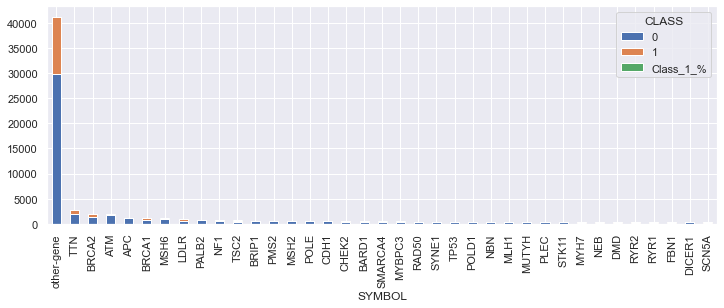

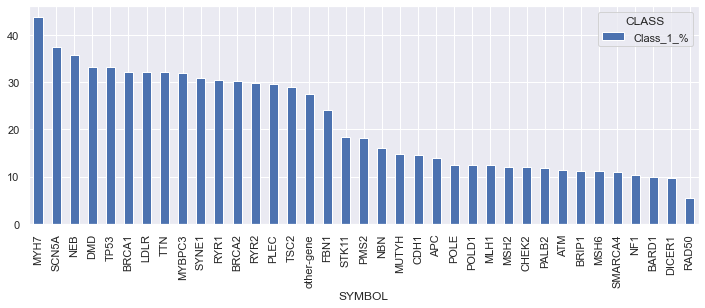

In [14]:
variant_in_feature(df.SYMBOL, class_1=True)
# Most variants occur at gene TTN
# Variants of class 1 are located with higher frequency at other genes

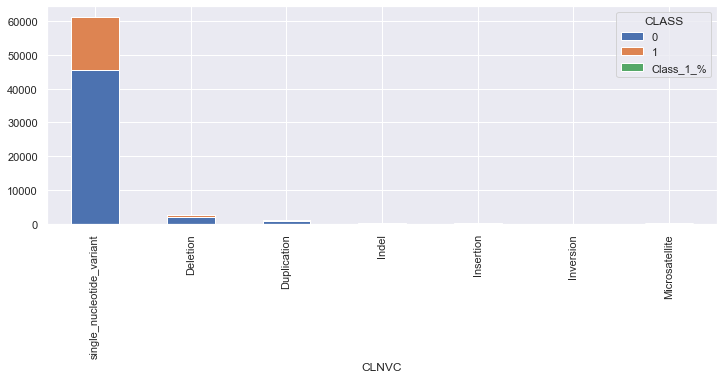

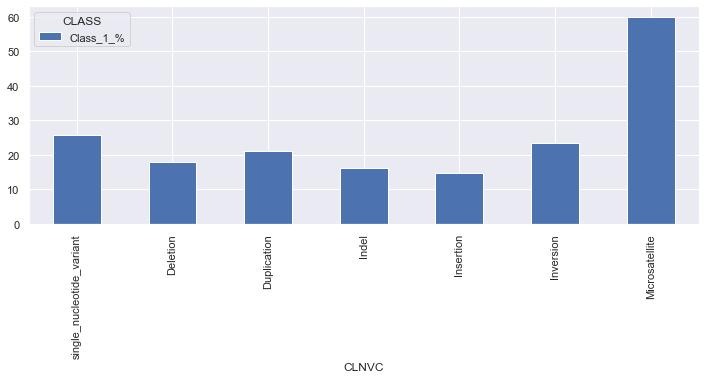

In [63]:
# Feature: CLNVC (Variant Type)
variant_in_feature(df.CLNVC, class_1=True)
# most varaints are the type of SNP
# Variants of class 1 are located with higher frequency at the variant type of microsatillete

In [64]:
# Feature: Exon location
#df.EXON.fillna('0', inplace = True)
#df['variant_exon'] = df.EXON.apply(lambda x: [int(s) for s in re.findall(r'\b\d+\b', x)][0])
#df.drop('EXON', axis =1, inplace = True)

In [65]:
#variant_in_feature(df['variant_exon'], class_1=True)
# variants of class frequency has no preferences to any exons

/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_63531/71236387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHROM'] = df['CHROM'].replace(list_chrom, 'other_chrom')


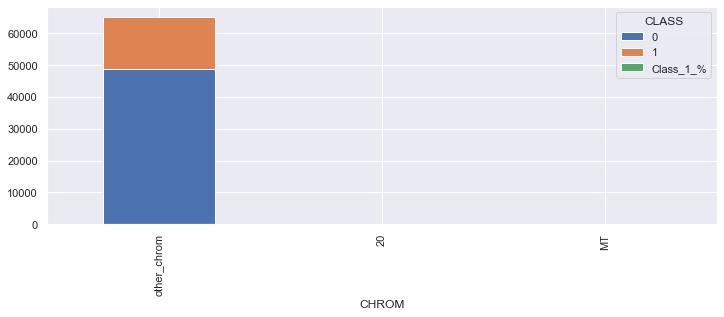

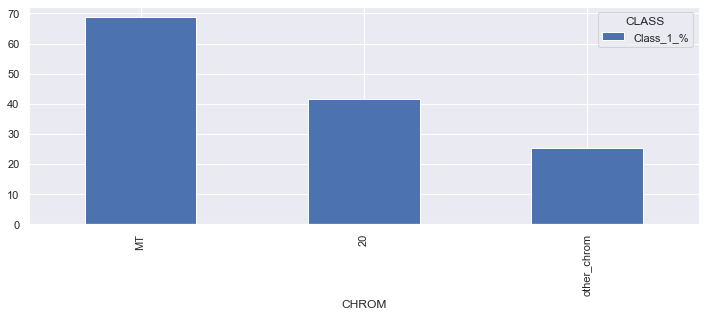

In [15]:
# feature "CHROM"
list_chrom = list(df.CHROM.unique())

list_chrom.remove('MT')
list_chrom.remove('20')
df['CHROM'] = df['CHROM'].replace(list_chrom, 'other_chrom')
df = df.astype({'CHROM': 'string'})
df.CHROM.unique()
variant_in_feature(df['CHROM'], class_1=True)

In [16]:
# feature MC
MC_list = df.MC.dropna().str.split(',').apply(lambda row: list(c.split('|')[1] for c in row))
MC_encoded = pd.get_dummies(MC_list.apply(pd.Series).stack()).sum(level=0)
MC_encoded = MC_encoded.reindex(index=MC_list.index)
df = df.join(MC_encoded).drop(columns=['MC'])

mccounts = {0: {},
            1: {},
           'All': {}
}
for col in MC_encoded.columns:
    for class_ in [0, 1]:
        mccounts[class_][col] = df.loc[df['CLASS'] == class_][col].sum()
        
    mccounts['All'][col] = df[col].sum()

mc_ct = pd.DataFrame.from_dict(mccounts)
mc_ct_all = mc_ct.sum(axis=0)
mc_ct_all.name ='All'
mc_ct=mc_ct.append(mc_ct_all, ignore_index=False)


/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_63531/1373119687.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  MC_encoded = pd.get_dummies(MC_list.apply(pd.Series).stack()).sum(level=0)
/var/folders/rg/kpn3fy794p9cgdns5sjmpzr80000gp/T/ipykernel_63531/1373119687.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mc_ct=mc_ct.append(mc_ct_all, ignore_index=False)


In [68]:
mc_ct['class_1'] = mc_ct[1]/mc_ct['All'] 
mc_ct

,0,1,All,class_1
2KB_upstream_variant,357.0,134.0,491.0,0.272912
3_prime_UTR_variant,536.0,263.0,799.0,0.329161
500B_downstream_variant,19.0,17.0,36.0,0.472222
5_prime_UTR_variant,1573.0,563.0,2136.0,0.263577
frameshift_variant,1746.0,115.0,1861.0,0.061795
intron_variant,9000.0,3369.0,12369.0,0.272374
missense_variant,24101.0,8664.0,32765.0,0.264429
nonsense,1666.0,117.0,1783.0,0.065620
splice_acceptor_variant,390.0,38.0,428.0,0.088785
splice_donor_variant,524.0,56.0,580.0,0.096552


In [19]:
from itertools import combinations
from scipy.stats import chi2_contingency

In [69]:
categorical_index = pd.MultiIndex.from_tuples(combinations(['CLASS','CHROM', 'IMPACT', 'SYMBOL', "CLNVC"], 2))

In [70]:
categorical_index

MultiIndex([( 'CLASS',  'CHROM'),
            ( 'CLASS', 'IMPACT'),
            ( 'CLASS', 'SYMBOL'),
            ( 'CLASS',  'CLNVC'),
            ( 'CHROM', 'IMPACT'),
            ( 'CHROM', 'SYMBOL'),
            ( 'CHROM',  'CLNVC'),
            ('IMPACT', 'SYMBOL'),
            ('IMPACT',  'CLNVC'),
            ('SYMBOL',  'CLNVC')],
           )

In [71]:
categoricals_corr = pd.DataFrame(categorical_index, columns = ['cols'])

In [72]:
def chisq_of_cols(row):
    c1, c2 = row[0], row[1]
    groupsizes = df.groupby([c1,c2]).size()
    ctsum = groupsizes.unstack(c1)
    
    return chi2_contingency(ctsum.fillna(0))[1]

In [73]:
categoricals_corr['chi2_p'] = categoricals_corr.cols.apply(chisq_of_cols)

In [74]:

categoricals_corr.index = categorical_index
categoricals_corr = categoricals_corr.chi2_p.unstack()

In [75]:
categoricals_corr

,CHROM,CLNVC,IMPACT,SYMBOL
CHROM,NaN,9.191884e-01,4.618892e-50,1.479202e-01
CLASS,0.000001,5.333976e-20,1.856664e-191,6.362397e-309
IMPACT,NaN,0.000000e+00,NaN,0.000000e+00
SYMBOL,NaN,8.688456e-84,NaN,NaN


Among these features, variant_exon is the least correlated

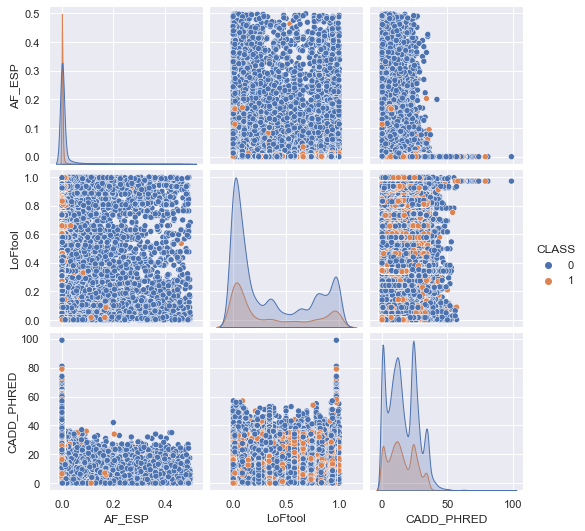

In [76]:
df2 = df[["AF_ESP","LoFtool","CADD_PHRED", "CLASS"]]
sns.pairplot(df2, hue="CLASS")

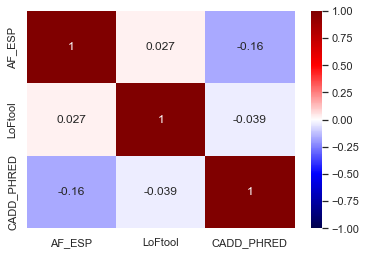

In [77]:
#corr = df.select_dtypes(exclude = ['object', 'int']).corr()
corr = df[["AF_ESP","LoFtool","CADD_PHRED"]].corr()
#import numpy as np

#mask = np.zeros_like(corr, dtype = np.bool)
#mask[np.triu_indices_from(mask)] = True
#f, ax = plt.subplots(figsize=(15,12))
#cmap = sns.diverging_palette(220, 10, as_cmap =True)

#sns.heatmap(corr, mask=mask, cmap=cmap, vmax = .5, center=0, square = True, linewidth =5, cbar_kws={"shrink": .5})
sns.heatmap(corr, cmap="seismic", annot=True, vmin=-1, vmax=1);

In [463]:
#snvs = df.loc[(df.REF.str.len()==1) & (df.ALT.str.len()==1)]
#indels = df.loc[(df.REF.str.len()>1) | (df.ALT.str.len()>1)]
    

In [473]:
#snp_indel = pd.concat(
#    [snvs.CLASS.value_counts(normalize = True).rename('snv_class'),
#     indels.CLASS.value_counts(normalize = True).rename('index_class')], axis =1)

In [466]:
#snp_indel.T.plot.bar(stacked=True, figsize=(12,4))

In [494]:
#disease_not_specified = df.CLASS.loc[(df.CLNDN=="not_specified") | 
#                                     (df.CLNDN == "not_provided") | 
#                                     (df.CLNDN == "not_specified|not_provided")].value_counts(normalize=True).rename("disease_not_specified")
#some_disease_specified = df.CLASS.loc[(df.CLNDN !="not_specified") | 
#                                     (df.CLNDN != "not_provided") | 
#                                     (df.CLNDN != "not_specified|not_provided")].value_counts(normalize=True).rename("some_disease_specified")

In [81]:
df = df.dropna()

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59392 entries, 6 to 65187
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CHROM                    59392 non-null  string 
 1   CLNVC                    59392 non-null  object 
 2   IMPACT                   59392 non-null  object 
 3   SYMBOL                   59392 non-null  object 
 4   AF_ESP                   59392 non-null  float64
 5   LoFtool                  59392 non-null  float64
 6   CADD_PHRED               59392 non-null  float64
 7   CLASS                    59392 non-null  int64  
 8   2KB_upstream_variant     59392 non-null  float64
 9   3_prime_UTR_variant      59392 non-null  float64
 10  500B_downstream_variant  59392 non-null  float64
 11  5_prime_UTR_variant      59392 non-null  float64
 12  frameshift_variant       59392 non-null  float64
 13  intron_variant           59392 non-null  float64
 14  missense_variant      

In [83]:
df.to_csv("genetic_EDA.csv")